#### Brief Intro

With no doubt, Convolutional Neural Networks (CNN) has been the most successful model for computer vision tasks. 

Convolutional operation has similar mechanism to the way that human eyes work in visual perception. When humans explore the visual world, the eyes behave in a pattern of alternative fixations and saccades. The saccadic eye movements bring the visual target to the fovea abruptly (about 20ms), and the target information is then processed during eye fixations when the eyes stay relatively stable (e.g 200ms). We are usually un-aware of the eye movements, as they are programed and executed automatically by cognitive brain process. Our brain then aggregate all these local information to a global decision, based on previous knowledge/experience. The visual field is not explored as a whole. Only a selective set of local positions are viewed, and that turns out to be enough to serve the perception needs in our daily lives (It means images are extremely redundant to serve the recognition/classification popurse. Duplicated and irrelavant information should be effectively discarded to gain efficiency, e.g through weighting and local operator (local operators also can be considered as weighting by penalizing weights of the positions outside the receptive field to 0). Images are too rich and also too costy.).

From this perspective, CNN is very much bio-inspired methodology： local-to-global, like divide-and-conquer (e.g to sort a list, you can sort the sublists (local) then merge to have the global solution). It acts like information selector and aggragator, grab the needed and throw away the rest. 

OK, too much talking, stop brain storming and code it.

#### Let code say

In [1]:
## load libs
%matplotlib inline
import time
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_mldata
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import OneHotEncoder

#### Load MNIST

In [2]:
mnist = fetch_mldata('mnist original', data_home = 'datasets/')
X, y = mnist['data'], mnist['target']
X.shape, y.shape ## shape check

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function fetch_mldata is deprecated; fetch_mldata was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function mldata_filename is deprecated; mldata_filename was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)


((70000, 784), (70000,))

#### Preprocess MNIST

In [3]:
X = X.T
X = X / 255.0
Y = OneHotEncoder().fit_transform(y.reshape(-1,1).astype('int32')).toarray().T
X.shape, Y.shape

((784, 70000), (10, 70000))

#### Make Train/Test Splits

In [4]:
m = 60000
X_train, X_test = X[:,:m].reshape(1,28,28,-1), X[:,m:].reshape(1,28,28,-1)
Y_train, Y_test = Y[:,:m], Y[:,m:]
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((1, 28, 28, 60000), (10, 60000), (1, 28, 28, 10000), (10, 10000))

#### Shuffle Train set

In [5]:
np.random.seed(54321)
shuffle = np.random.permutation(m)
X_train, Y_train = X_train[:,:,:,shuffle], Y_train[:,shuffle]
X_train.shape, Y_train.shape

((1, 28, 28, 60000), (10, 60000))

#### Visual check

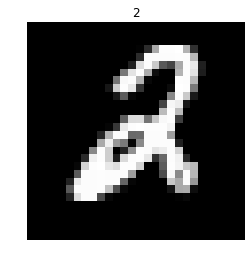

In [6]:
idx = 134
plt.imshow(X_train[:,:,:,idx].squeeze(), cmap = 'binary_r')
plt.title(np.argmax(Y_train[:,idx]))
plt.axis('off')
plt.show()

#### Define network

In [7]:
## input layer
input_depth  = 1
input_height = 28
input_width  = 28

In [8]:
## convolution layer
conv_depth  = 2
conv_height = 3
conv_width  = 3

## trainable parameters connecting input & convolution layers
W1 = np.random.randn(conv_depth, input_depth, conv_height, conv_width)
b1 = np.zeros((conv_depth, 1))

In [9]:
## densely connected (fc) layer
fc_dims = 32
flatten_dims = conv_depth * (input_height - conv_height + 1) * (input_width - conv_width + 1)

## trainable parameters connecting convolution & dense layers
W2 = np.random.randn(fc_dims, flatten_dims)
b2 = np.zeros((fc_dims, 1))

In [10]:
## output layer
output_dims = 10

## trainable parameters connecting dense & output layers
W3 = np.random.randn(output_dims, fc_dims)
b3 = np.zeros((output_dims, 1))

#### Training CNN

In [11]:
## prepare inputs
Input  = X_train.copy()
Target = Y_train.copy()
Input.shape, Target.shape

((1, 28, 28, 60000), (10, 60000))

In [12]:
## initialize convolution output
conv_output_height = input_height - conv_height + 1
conv_output_width  = input_width  - conv_width + 1
conv_output = np.zeros((conv_depth, conv_output_height, conv_output_width, Input.shape[-1]))

for epoch in range(20):
    
    #------------------------------------------------------------------FORWARD BLOCK
    ## feed forward: convolution operation
    for f in range(conv_depth):
        for r in range(conv_output_height):
            for c in range(conv_output_width):
                current_patch  = Input[:, r : r + conv_height, c : c + conv_width]
                current_filter = np.expand_dims(W1[f,:,:,:], axis = 3) ## to match shape for broadcasting
                conv_output[f, r, c] = (current_patch * current_filter + b1[f]).reshape(-1, Input.shape[-1]).sum(axis = 0) ## reshape 2X faster
                # conv_output[f, r, c] += (current_patch * current_filter + b1[f]).sum(axis = 0).sum(axis = 0).sum(axis = 0)

    ## feed forward: flatten the convolution output
    conv_output_flatten = conv_output.reshape(-1, Input.shape[-1])
    A1 = 1 / (1 + np.exp(-conv_output_flatten)) ## sigmoid

    ## feed forward: affine operation
    Z2 = W2 @ A1 + b2
    A2 = 1/(1 + np.exp(-Z2))

    ## geed forward: affine + softmax operation
    Z3 = W3 @ A2 + b3
    Z3 = Z3 - np.max(Z3, axis = 0)
    A3 = np.exp(Z3)/np.exp(Z3).sum(axis = 0)

    
    #------------------------------------------------------------------BACKWARD  BLOCK
    ## backpropagation: softmax layer
    dZ3 = A3 - Y_train
    dW3 = dZ3 @ A2.T / Input.shape[-1]
    db3 = dZ3.mean(axis = 1, keepdims = True)

    ## backpropagation: dense layer
    dA2 = W3.T @ dZ3
    dZ2 = dA2 * A2 * (1 - A2)
    dW2 = dZ2 @ A1.T / Input.shape[-1]
    db2 = dZ2.mean(axis = 1, keepdims = True)

    ## backpropagation: convolution layer
    dA1 = W2.T @ dZ2
    d_conv_flatten = dA1 * A1 * (1 - A1)
    d_conv_matrix = d_conv_flatten.reshape(conv_output.shape)

    ## backpropagation: convolution layer --> weight
    dW1 = np.zeros(W1.shape)
    for in_c in range(Input.shape[0]):
        for out_c in range(conv_output.shape[0]):
            for r in range(conv_height):
                for c in range(conv_width):
                    conv_input_patch = Input[in_c, r : r + conv_output_height, c : c + conv_output_width, :] ## conv input
                    conv_output_vals = d_conv_matrix[out_c] ## conv results
                    dW1[out_c, in_c, r, c] = np.sum(conv_input_patch * conv_output_vals)/Input.shape[-1]

    ## backpropagation: convolution layer --> bias
    db1 = d_conv_matrix.sum(axis = 1).sum(axis = 1).mean(axis = 1, keepdims = True)

    # equivalent
    # db1 = np.zeros((b1.shape))
    # for out_c in range(d_conv_matrix.shape[0]):
    #    db1[out_c] += d_conv_matrix[out_c].sum()/Input.shape[-1]

    ## backpropagation: convolution layer --> Input
    dInput = np.zeros_like(Input)
    for in_c in range(Input.shape[0]):
        for out_c in range(conv_output.shape[0]):
            current_filter = np.expand_dims(W1[out_c, in_c], axis = 2)
            for r in range(conv_output_height):
                for c in range(conv_output_width):
                    d_conv_val = d_conv_matrix[out_c, in_c, r, c]
                    dInput[in_c, r : r+conv_height, c : c + conv_width, :] += d_conv_val * current_filter

    #------------------------------------------------------------------ UPDATE PARAMETERS
    ## update model
    lr = 1
    W3 -= dW3 * lr
    W2 -= dW2 * lr
    W1 -= dW1 * lr
    b3 -= db3 * lr
    b2 -= db2 * lr
    b1 -= db1 * lr

    ## compute loss
    Loss = -np.mean(Y_train * np.log(A3), axis = 1)

    print('epoch:', epoch, ', loss:', Loss.sum())

epoch: 0 , loss: [1.28140686 0.20822068 0.2338827  0.46949416 0.60362163 0.17409459
 0.35062963 1.02211311 1.32937071 0.04804767]
epoch: 1 , loss: [0.38369461 0.06354422 0.77907208 0.20330568 0.38941393 0.18225178
 0.46335044 0.22145518 0.68721877 1.18083523]
epoch: 2 , loss: [0.34118477 0.98553669 0.58973446 0.09616901 0.11638067 0.16605581
 0.25018618 0.26129972 0.40057913 0.76627435]
epoch: 3 , loss: [0.13881807 0.66915701 0.38335981 0.55071828 0.3880977  0.23016209
 0.24817241 0.08562567 0.22102089 0.52127314]
epoch: 4 , loss: [0.55372952 0.38240065 0.14696803 0.54680683 0.17156462 0.17519124
 0.13035284 0.70305301 0.20451274 0.36796369]
epoch: 5 , loss: [0.34151146 0.16762261 0.26628403 0.32332559 0.20978761 0.18224469
 0.3076453  0.46574045 0.17083644 0.18504516]
epoch: 6 , loss: [0.21586048 0.32785749 0.19406651 0.20420862 0.21118384 0.21637319
 0.20095451 0.29251818 0.2560406  0.24154615]
epoch: 7 , loss: [0.23242883 0.22555531 0.25360815 0.25162868 0.23244112 0.21426809
 0.244

#### Test

In [13]:
## initialize convolution output
Input = X_test.copy()
conv_output_height = input_height - conv_height + 1
conv_output_width  = input_width  - conv_width + 1
conv_output = np.zeros((conv_depth, conv_output_height, conv_output_width, Input.shape[-1]))

## feed forward: convolution operation
for f in range(conv_depth):
    for r in range(conv_output_height):
        for c in range(conv_output_width):
            current_patch  = Input[:, r : r + conv_height, c : c + conv_width]
            current_filter = np.expand_dims(W1[f,:,:,:], axis = 3) ## to match shape for broadcasting
            conv_output[f, r, c] = (current_patch * current_filter + b1[f]).reshape(-1, Input.shape[-1]).sum(axis = 0) ## reshape 2X faster
            # conv_output[f, r, c] += (current_patch * current_filter + b1[f]).sum(axis = 0).sum(axis = 0).sum(axis = 0)

## feed forward: flatten the convolution output
conv_output_flatten = conv_output.reshape(-1, Input.shape[-1])
A1 = 1 / (1 + np.exp(-conv_output_flatten)) ## sigmoid

## feed forward: affine operation
Z2 = W2 @ A1 + b2
A2 = 1/(1 + np.exp(-Z2))

## geed forward: affine + softmax operation
Z3 = W3 @ A2 + b3
Z3 = Z3 - np.max(Z3, axis = 0)
A3 = np.exp(Z3)/np.exp(Z3).sum(axis = 0)

In [17]:
preds = np.argmax(A3, axis = 0)
truth = np.argmax(Y_test, axis = 0)

#### Results Report

In [20]:
print(accuracy_score(truth, preds))

0.1135


In [23]:
print(confusion_matrix(truth, preds))

[[   0  980    0    0    0    0    0    0    0    0]
 [   0 1135    0    0    0    0    0    0    0    0]
 [   0 1032    0    0    0    0    0    0    0    0]
 [   0 1010    0    0    0    0    0    0    0    0]
 [   0  982    0    0    0    0    0    0    0    0]
 [   0  892    0    0    0    0    0    0    0    0]
 [   0  958    0    0    0    0    0    0    0    0]
 [   0 1028    0    0    0    0    0    0    0    0]
 [   0  974    0    0    0    0    0    0    0    0]
 [   0 1009    0    0    0    0    0    0    0    0]]


In [19]:
print(classification_report(truth, preds))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       980
           1       0.11      1.00      0.20      1135
           2       0.00      0.00      0.00      1032
           3       0.00      0.00      0.00      1010
           4       0.00      0.00      0.00       982
           5       0.00      0.00      0.00       892
           6       0.00      0.00      0.00       958
           7       0.00      0.00      0.00      1028
           8       0.00      0.00      0.00       974
           9       0.00      0.00      0.00      1009

   micro avg       0.11      0.11      0.11     10000
   macro avg       0.01      0.10      0.02     10000
weighted avg       0.01      0.11      0.02     10000

